# Regression

In this Notebook we will examine bitcoin prices and see if we can predict the value.

https://www.kaggle.com/mczielinski/bitcoin-historical-data/data

Data under CC BY-SA 4.0 License

https://www.kaggle.com/mczielinski/bitcoin-historical-data


Predict bitcoin prices based on the previous days activity

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble, linear_model, model_selection, preprocessing, svm
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import PredictionError, ResidualsPlot

/home/datalass1/miniconda3/envs/pythonista/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


yellowbrick is used for machine learning visualisation. 
http://www.scikit-yb.org/en/latest/

In [2]:
%%time

# Resampling data from minute interval to day
bit_df = pd.read_csv('../data/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv')

# Convert unix time to datetime
bit_df['date'] = pd.to_datetime(bit_df.Timestamp, unit='s')

# Reset index
bit_df = bit_df.set_index('date')

# Rename columns so easier to code
bit_df = bit_df.rename(columns={'Open':'open', 'High': 'hi', 'Low': 'lo', 
                       'Close': 'close', 'Volume_(BTC)': 'vol_btc',
                       'Volume_(Currency)': 'vol_cur', 
                       'Weighted_Price': 'wp', 'Timestamp': 'ts'})
# Resample and only use recent samples that aren't missing
bit_df = bit_df.resample('d').agg({'open': 'first', #first value from open column
                                   'hi': 'max', #max value from hi column
                                   'lo': 'min', #min value from lo column ETC
                                   'close': 'last', 'vol_btc': 'sum',
    'vol_cur': 'sum', 'wp': 'mean', 'ts': 'min'}).iloc[-1000:]

# drop last row as it is not complete
bit_df = bit_df.iloc[:-1]

CPU times: user 1.68 s, sys: 319 ms, total: 2 s
Wall time: 1.77 s


What does the resample do?: The d string is taking data from the same DAY and aggregating it. The number of rows goes from 1574274 to 999 because we used iloc to chop the last 1000<br>


A simple example is shown https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.resample.Resampler.aggregate.html

In [3]:
bit_df

,open,hi,lo,close,vol_btc,vol_cur,wp,ts
date,,,,,,,,
2015-04-15,221.05,224.52,218.09,224.35,9137.584626,2.029524e+06,222.270771,1.429056e+09
2015-04-16,224.35,230.75,223.66,229.45,8636.837666,1.970069e+06,227.779413,1.429142e+09
2015-04-17,229.45,230.08,220.46,223.62,7738.360003,1.741497e+06,224.970863,1.429229e+09
2015-04-18,223.55,224.04,222.18,224.02,5065.649127,1.131269e+06,223.398170,1.429315e+09
2015-04-19,224.02,226.72,223.44,224.03,5279.787312,1.185860e+06,224.667792,1.429402e+09
2015-04-20,224.03,227.45,223.45,225.37,7964.055364,1.793096e+06,225.063422,1.429488e+09
2015-04-21,225.35,235.89,224.01,235.89,10191.153344,2.325789e+06,227.170562,1.429574e+09
2015-04-22,235.89,238.60,232.78,233.98,7661.273982,1.807241e+06,236.029556,1.429661e+09
2015-04-23,233.96,236.54,232.79,235.99,6908.700188,1.622914e+06,234.896309,1.429747e+09


In [4]:
bit_df.head().T

date,2015-04-15 00:00:00,2015-04-16 00:00:00,2015-04-17 00:00:00,2015-04-18 00:00:00,2015-04-19 00:00:00
open,2.210500e+02,2.243500e+02,2.294500e+02,2.235500e+02,2.240200e+02
hi,2.245200e+02,2.307500e+02,2.300800e+02,2.240400e+02,2.267200e+02
lo,2.180900e+02,2.236600e+02,2.204600e+02,2.221800e+02,2.234400e+02
close,2.243500e+02,2.294500e+02,2.236200e+02,2.240200e+02,2.240300e+02
vol_btc,9.137585e+03,8.636838e+03,7.738360e+03,5.065649e+03,5.279787e+03
vol_cur,2.029524e+06,1.970069e+06,1.741497e+06,1.131269e+06,1.185860e+06
wp,2.222708e+02,2.277794e+02,2.249709e+02,2.233982e+02,2.246678e+02
ts,1.429056e+09,1.429142e+09,1.429229e+09,1.429315e+09,1.429402e+09


In [5]:
bit_df.dtypes

open       float64
hi         float64
lo         float64
close      float64
vol_btc    float64
vol_cur    float64
wp         float64
ts         float64
dtype: object

there is no float64 type in python! numpy, pandas, scikitlearn use python as a wrapper for lower level code, such a C. So float64 is a C type implemented at the numpy level.<br>

In [6]:
#getting summary statistics
bit_df.describe()

,open,hi,lo,close,vol_btc,vol_cur,wp,ts
count,999.00000,999.000000,999.000000,999.000000,999.000000,9.990000e+02,999.000000,9.990000e+02
mean,1838.11015,1914.705946,1757.861101,1854.054895,10350.019927,3.553735e+07,1842.224578,1.472170e+09
std,3169.30283,3346.396825,2966.458499,3201.173766,9947.604406,1.097365e+08,3165.632076,2.492906e+07
min,211.16000,224.040000,0.060000,211.160000,1525.187302,7.925465e+05,215.969046,1.429056e+09
25%,384.61500,393.500000,371.300000,384.850000,5320.152105,2.297687e+06,384.227045,1.450613e+09
50%,629.79000,639.850000,618.130000,630.830000,7367.614526,3.484114e+06,632.673702,1.472170e+09
75%,1454.14500,1512.965000,1440.095000,1502.495000,11954.181722,1.985804e+07,1471.613323,1.493726e+09
max,19650.02000,19891.990000,19010.000000,19650.010000,165763.024424,1.393385e+09,19537.276941,1.515283e+09


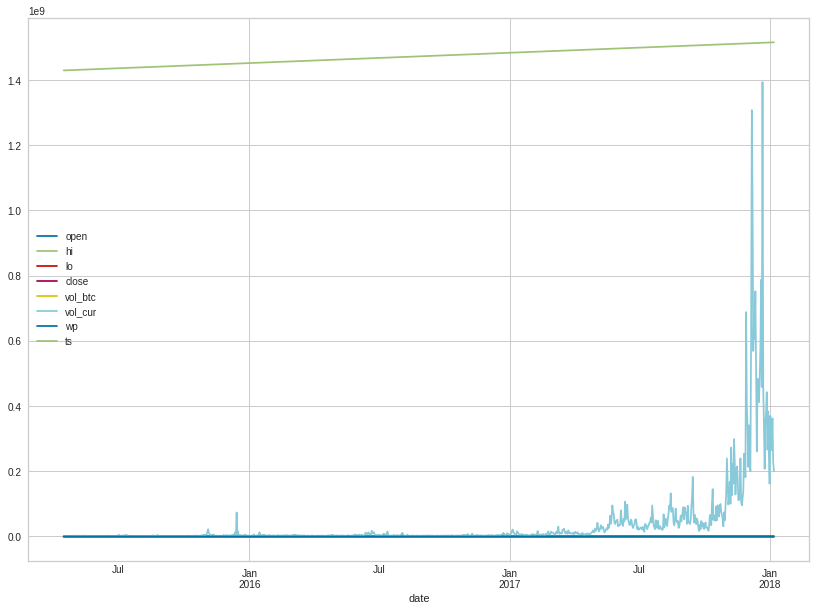

In [7]:
bit_df.plot(figsize=(14,10));

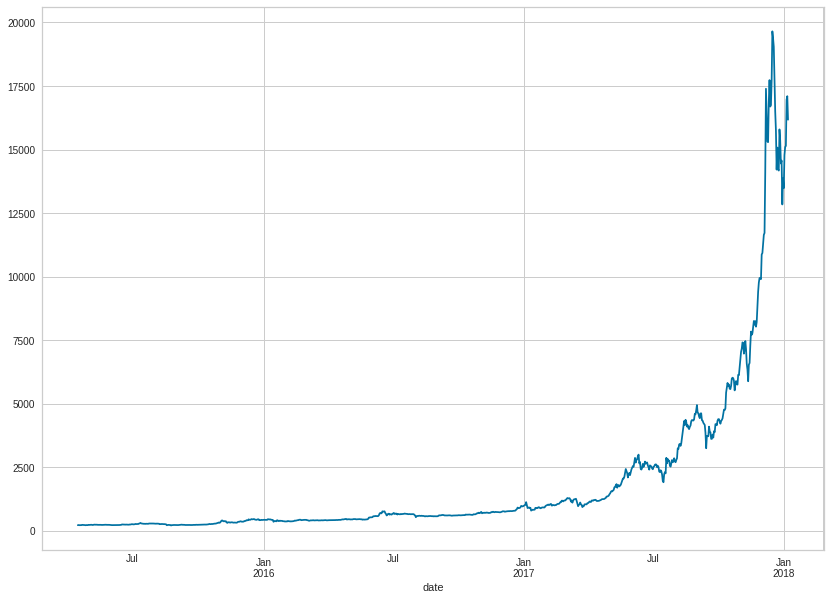

In [8]:
bit_df.close.plot(figsize=(14,10));

Can we predict the close price for the next day?

## Exercise: Load data
This exercise looks at predicting the size of forest fires based on meteorological data https://archive.ics.uci.edu/ml/datasets/Forest+Fires

The file is in ``../data/forestfires.csv``

* Read the data into a DataFrame
* Examine the types
* Describe the data

Attribute information:

   For more information, read [Cortez and Morais, 2007].

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20 #Fine Fuel Moisture Code (FFMC)
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 #Duff Moisture Code
   7. DC - DC index from the FWI system: 7.9 to 860.6 #Drought Code
   8. ISI - ISI index from the FWI system: 0.0 to 56.10 #Initial Spread Index
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 

the burned area output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform. To reduce
skewness and improve symmetry, the logarithm function y = ln(x + 1), which is a common transformation that tends to improve regression results for right-skewed targets

   

In [9]:
ff = pd.read_csv('../data/forestfires.csv')

In [10]:
ff.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

The area column is the one we want to predict

In [11]:
ff.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [12]:
ff.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


look at area summary statistics....the 75% quartile is 6.57 then the max is 1090.84! The data is very skewed. 

In [13]:
#confirm that there are no null values
ff.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

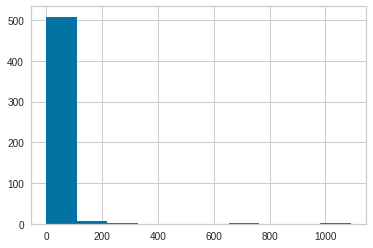

In [14]:
ff.area.hist();

## Can we predict tomorrow's close based on today's info?
We will use a row of data for input. We will call the input X and the prediction y. This is called "supervised learning" as we will feed in both X and y to train the model.

Let's use a model called Linear Regression. This performs better if we *standardize* the data (0 mean, 1 std).

For 2 dimensions this takes the form of 

\begin{align}
y = m*x + b
\end{align}

M is the slope (or coefficient) and b is the intercept.

Let's see if we can predict the open price from the ts component.

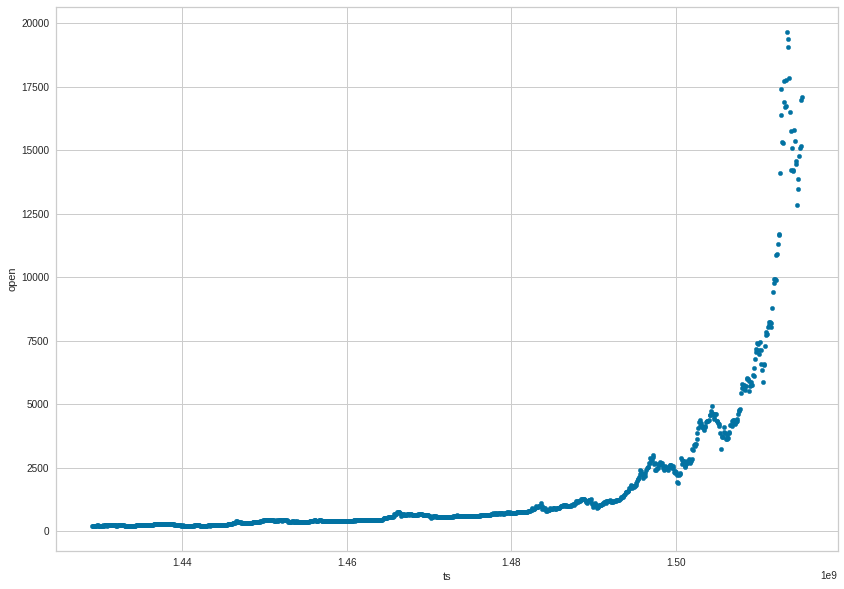

In [15]:
#plotting time and the opening price....is there a relationship?
bit_df.plot(kind='scatter', x='ts', y='open', figsize=(14,10))

In [16]:
# Create our input (X) and our labelled data (y) to train our model
X = bit_df[['ts']].iloc[:-1]  # drop last row because we don't know what future is
y = bit_df.close.shift(-1).iloc[:-1]

In [17]:
#this is a DEMO to understand the pandas shift method and why we use it
#to show what is going on, why did we shift all close values? concat used below. 
pd.concat([bit_df.close, bit_df.close.shift(-1)], axis=1)#.iloc[:-1]

,close,close
date,,
2015-04-15,224.35,229.45
2015-04-16,229.45,223.62
2015-04-17,223.62,224.02
2015-04-18,224.02,224.03
2015-04-19,224.03,225.37
2015-04-20,225.37,235.89
2015-04-21,235.89,233.98
2015-04-22,233.98,235.99
2015-04-23,235.99,231.51


In [18]:
# Train a model and predict output if it were given X
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)
pred = lr_model.predict(X)

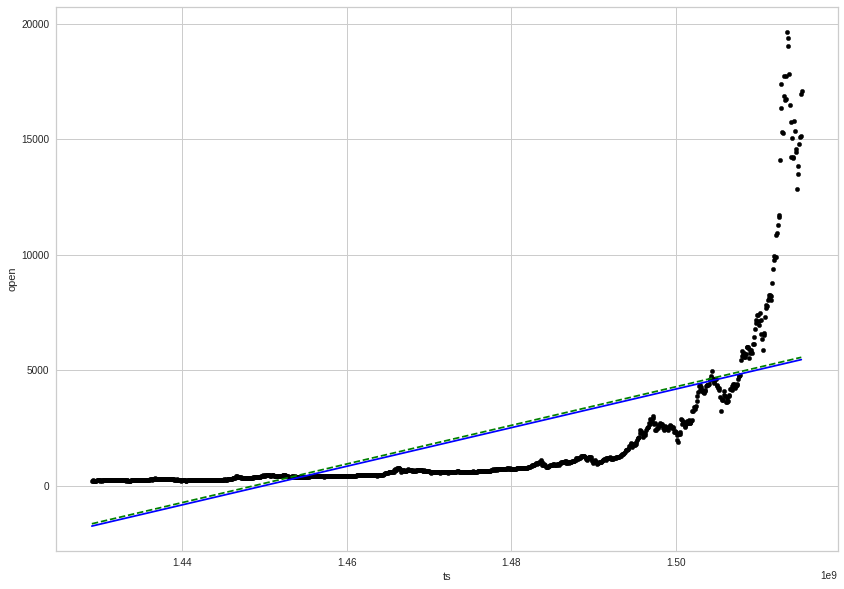

In [19]:
# Plot the real data, our prediction (blue), and the model from the coeffictient (green shifted)
ax = bit_df.plot(kind='scatter', x='ts', y='open', color='black', figsize=(14,10))
ax.plot(X, pred, color='blue')  # matplotlib plot
ax.plot(X, X*lr_model.coef_ + lr_model.intercept_+ 100, linestyle='--', color='green')

this linear regression has only one degree of freedom. 

so it is not the best fitting model for bitcoin predictions

In [20]:
# Vertical distance between line and point is the error. *Ordinary Least Squares* 
# regression tries to minimize the square of the distance.
mean_squared_error(y, pred)

5905906.764562201

In [21]:
# R2 score is a measure from 0-100
# 0 - the model explains none of the variation
# 100 - 100% of the variation is explained by the model
print(r2_score(y, pred))
# Not that the .score method gives the same value
print(lr_model.score(X, y))

0.42352430530848306
0.42352430530848306


## Exercise: Regression

* Use linear regression to predict ``area`` from the other columns. (If you have ``object`` data columns, you can create *dummy columns* using ``pd.get_dummies``, ``pd.concat``, and ``pd.drop``)
* What is your score?

**the area column is the one I would like to predict from**


In [22]:
ff.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [23]:
#DEMO: what get_dummies creates
s1 = ['yes', 'no', np.nan, 'yes', 'no', 'no', np.nan]
pd.get_dummies(s1)

,no,yes
0,0,1
1,1,0
2,0,0
3,0,1
4,1,0
5,1,0
6,0,0


pandas get_dummies will convert discrete/categorical values into binary/indicator/dummy variables 0 or 1, also known as sorting the variables into mutually exclusive categories (both can't be true at the same time)

In [24]:
yff = ff.area
Xff = pd.get_dummies(ff).drop(columns=['area'])
#test keeping area in the model for data leakage results
#the result is a perfect score! 

make a linear regression model

In [57]:
ff_lr = linear_model.LinearRegression()
ff_lr.fit(Xff, yff)
ff_lr.score(Xff, yff)
#4% is not a great score, but it is a difficult regression problem! 
#we will improve this score in the next ff section

0.04578209650808518

### Bonus - Visualize the errors
You can plot the actuals and the predicted values. It looks like our model does a pretty poor job

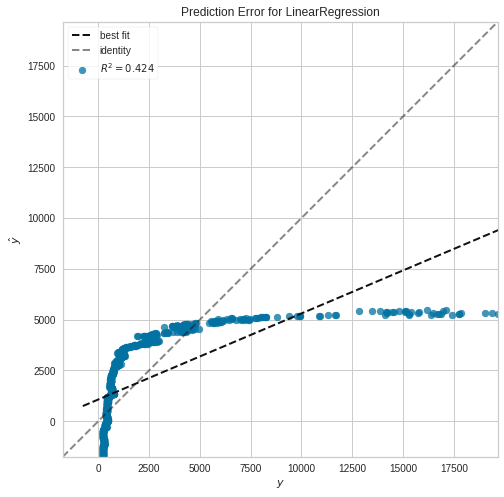

In [29]:
# Prediction error plot from Yellowbrick
# plot of actual (blue) vs predicted (black dash)
# ideally would be around 45 degree line
fig, ax = plt.subplots(figsize=(10, 8))
err_viz = PredictionError(lr_model)
# Model is already fit
#err_viz.fit(X, y)
err_viz.score(X, y)
err_viz.poof()

             close         pred          err
date                                        
2015-04-15  229.45 -1748.583025 -1978.033025
2015-04-16  223.62 -1741.352793 -1964.972793
2015-04-17  224.02 -1734.122560 -1958.142560
2015-04-18  224.03 -1726.892328 -1950.922328
2015-04-19  225.37 -1719.662095 -1945.032095


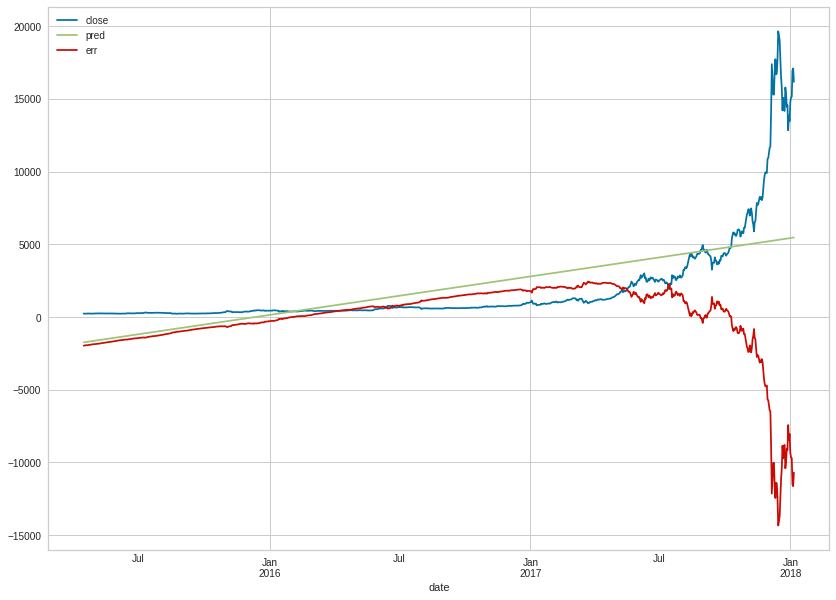

In [30]:
# plot result
y_df = pd.DataFrame(y)
y_df['pred'] = pred #create a column with the pred
#error is model predicted value subtract the y value
y_df['err'] = y_df.pred - y_df.close
print(y_df.head())

(y_df
 #.iloc[-50:]
 .plot(figsize=(14,10))
)

## Bonus Exercise: Visualize the errors
Plot y and predicted y

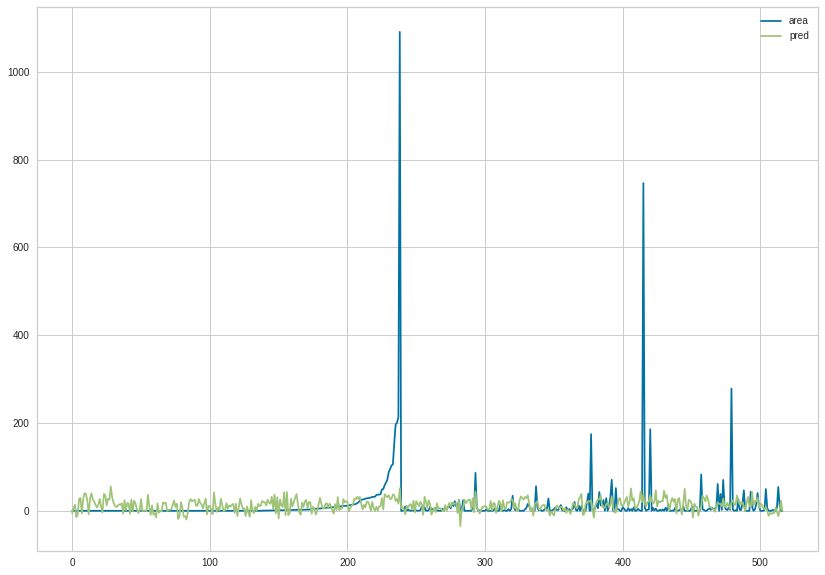

In [31]:
vis_df = pd.DataFrame(ff.area)
vis_df['pred'] = ff_lr.predict(Xff)
vis_df.plot(figsize=(14,10))

## Try More Features
In an attempt to get a better model we are going to use more features to make a prediction

It is important to perform standisation to the data so that some of the features that have larger values are not weighted more than others in the model.

In [32]:
# drop last row because we don't know what future is

X = (bit_df
         .drop(['close'], axis=1)
         .iloc[:-1])
y = bit_df.close.shift(-1).iloc[:-1]
cols = X.columns

In [33]:
# The describe method on a dataframe gives a statistical summary of the columns
X.describe().T

,count,mean,std,min,25%,50%,75%,max
open,998.0,1.822819e+03,3.133804e+03,2.111600e+02,3.845275e+02,6.289900e+02,1.423513e+03,1.965002e+04
hi,998.0,1.899475e+03,3.313250e+03,2.240400e+02,3.927500e+02,6.388700e+02,1.486370e+03,1.989199e+04
lo,998.0,1.743836e+03,2.934620e+03,6.000000e-02,3.712350e+02,6.178400e+02,1.412628e+03,1.901000e+04
vol_btc,998.0,1.034816e+04,9.952419e+03,1.525187e+03,5.318074e+03,7.365385e+03,1.188516e+04,1.657630e+05
vol_cur,998.0,3.537227e+07,1.096674e+08,7.925465e+05,2.297677e+06,3.480134e+06,1.957041e+07,1.393385e+09
wp,998.0,1.827510e+03,3.132853e+03,2.159690e+02,3.841825e+02,6.323453e+02,1.452074e+03,1.953728e+04
ts,998.0,1.472126e+09,2.490412e+07,1.429056e+09,1.450591e+09,1.472126e+09,1.493662e+09,1.515197e+09


In [34]:
# We are going to scale the data so that volume and ts don't get more
# weight that other values
ss = preprocessing.StandardScaler()
ss.fit(X)
X = ss.transform(X) #transform will produce a numpy array
X = pd.DataFrame(X, columns=cols)

In [37]:
# We can now see that the data has a mean close to 0
# and a std of 1
X.describe().T

,count,mean,std,min,25%,50%,75%,max
open,998.0,-5.695733e-17,1.000501,-0.514540,-0.459190,-0.381143,-0.127483,5.691531
hi,998.0,0.000000e+00,1.000501,-0.505931,-0.454985,-0.380665,-0.124745,5.433195
lo,998.0,-5.695733e-17,1.000501,-0.594506,-0.467961,-0.383886,-0.112919,5.886561
vol_btc,998.0,9.967533e-17,1.000501,-0.886960,-0.505667,-0.299854,0.154512,15.623617
vol_cur,998.0,0.000000e+00,1.000501,-0.315473,-0.301741,-0.290954,-0.144161,12.389219
wp,998.0,-5.695733e-17,1.000501,-0.514658,-0.460938,-0.381685,-0.119898,5.655753
ts,998.0,-5.695733e-17,1.000501,-1.730316,-0.865158,0.000000,0.865158,1.730316


In [44]:
lr_model2 = linear_model.LinearRegression()
lr_model2.fit(X, y)
pred = lr_model2.predict(X)
lr_model2.score(X, y)
#99% of the variance is captured! so looks good

0.99315208629409

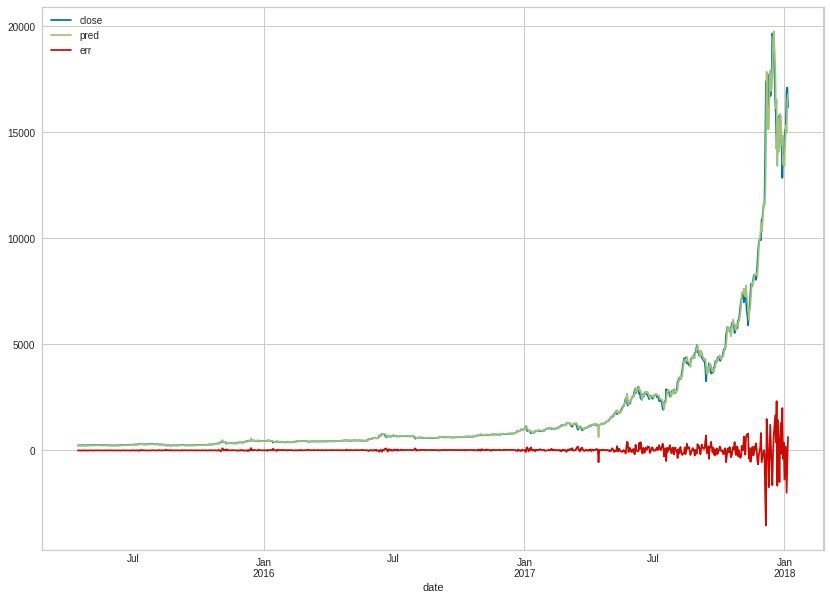

In [43]:
# plot result
y_df = pd.DataFrame(y)
y_df['pred'] = pred
y_df['err'] = y_df.pred - y_df.close
y_df.plot(figsize=(14,10));
#but the error does fluctuate so would you want to invest based on this model?

Zoom into the plot! Having a look at the last 50 values

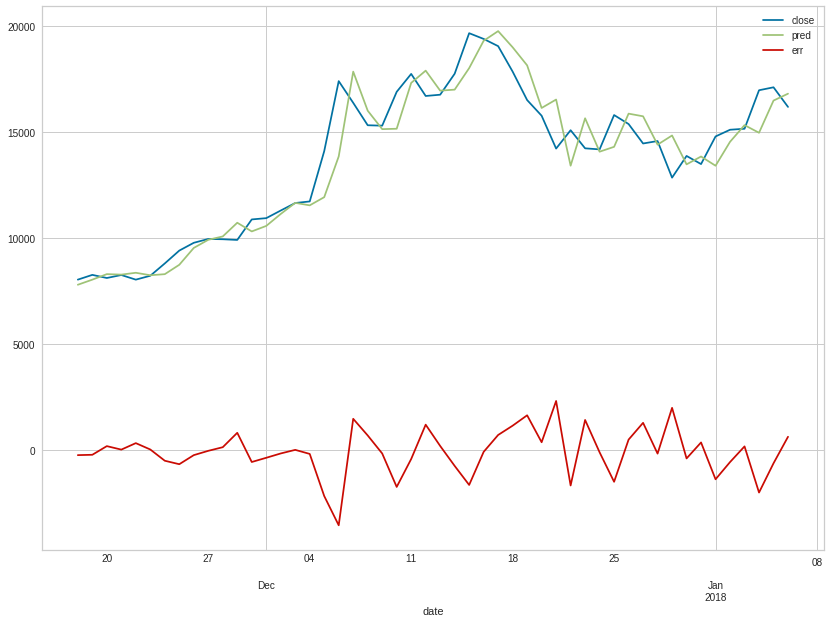

In [46]:
# plot result
y_df = pd.DataFrame(y)
y_df['pred'] = pred
y_df['err'] = y_df.pred - y_df.close
y_df.iloc[-50:].plot(figsize=(14,10));

In [47]:
# our scores get worse with recent data
lr_model2.score(X[-50:], y[-50:])

0.8945969866884239

as the bitcoin close values fluctuate more, so does our model and the error is increased

In [50]:
lr_model2.coef_

array([-1167.23492404,  1455.22180076,  1485.18244337,     4.81798323,
          73.9503874 ,  1345.13824172,    11.66531061])

In [51]:
list(zip(X.columns, lr_model2.coef_))

[('open', -1167.2349240376466),
 ('hi', 1455.221800758892),
 ('lo', 1485.1824433677234),
 ('vol_btc', 4.817983231216402),
 ('vol_cur', 73.95038739700563),
 ('wp', 1345.1382417241132),
 ('ts', 11.665310611455347)]

In [52]:
# These coefficients correspond to the columns in X
pd.DataFrame(list(zip(X.columns, lr_model2.coef_)), columns=['Feature', 'Coeff'])

,Feature,Coeff
0,open,-1167.234924
1,hi,1455.221801
2,lo,1485.182443
3,vol_btc,4.817983
4,vol_cur,73.950387
5,wp,1345.138242
6,ts,11.665311


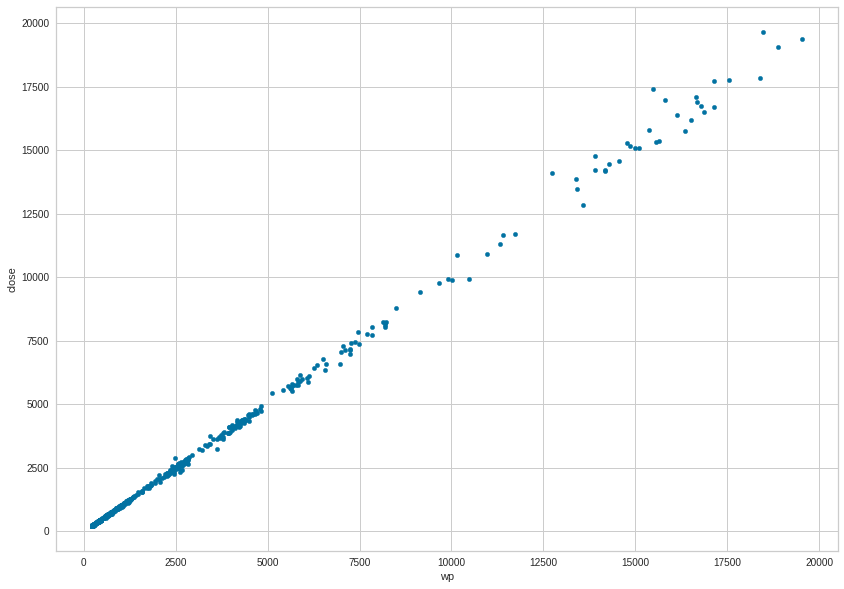

In [54]:
bit_df.plot(kind='scatter', x='wp', y='close', figsize=(14,10));

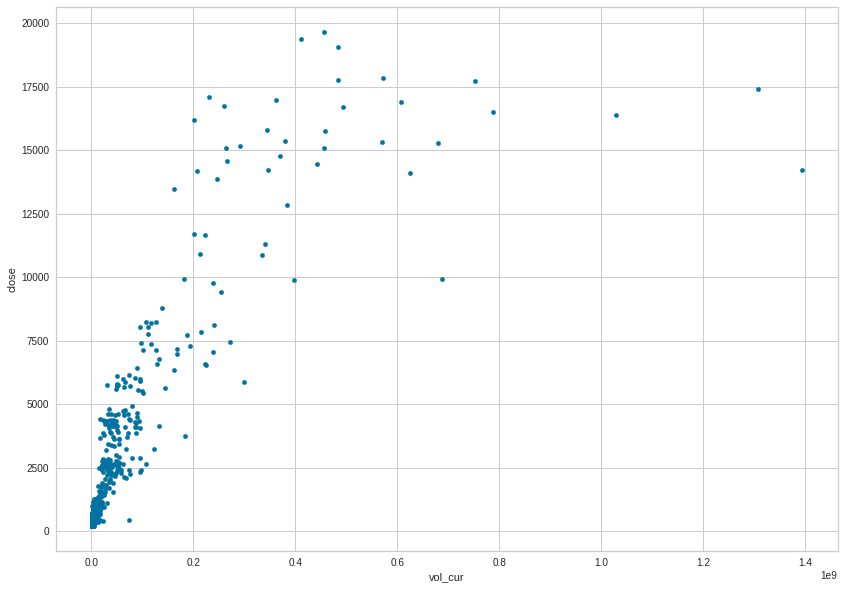

In [55]:
bit_df.plot(kind='scatter', x='vol_cur', y='close', figsize=(14,10));

## Exercise: Regression
* Try scaling the input and using the log of the area and see if you get a better score.

* Examine the coefficients



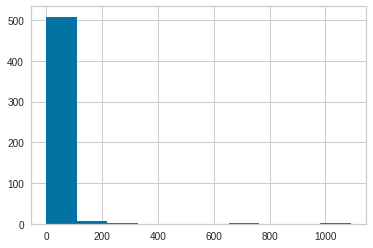

In [60]:
ff.area.hist(); #values between 0 and c1000

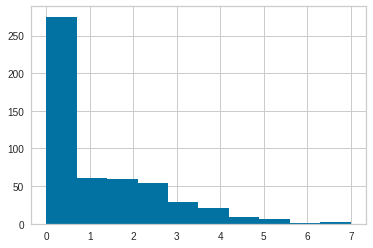

In [63]:
np.log((ff.area)+1).hist(); #values between 0 and 7

so lets add the log function to the standard scaler

In [56]:
ss_ff = preprocessing.StandardScaler()
ss_ff.fit(Xff)
X_ff_scaled = ss_ff.transform(Xff)
X_ff_scaled = pd.DataFrame(X_ff_scaled, columns=Xff.columns)
y_ff_scaled = np.log(ff.area+1)

In [66]:
ff_lr_scaled = linear_model.LinearRegression()
#fit the model
ff_lr_scaled.fit(X_ff_scaled, y_ff_scaled)
#score the model
ff_lr_scaled.score(X_ff_scaled, y_ff_scaled)
#a jump from 4% to 7%, same data but scaling does improve the model
#the next step would be to use some feature engineering to add other variables

0.07425336478182365

In [67]:
pd.DataFrame(list(zip(X_ff_scaled.columns, ff_lr_scaled.coef_)),
             columns=['Feature', 'Coeff'])

,Feature,Coeff
0,X,1.203493e-01
1,Y,-2.145322e-02
2,FFMC,4.241536e-02
3,DMC,2.674440e-01
4,DC,-4.978849e-01
5,ISI,-6.769677e-02
6,temp,2.076279e-01
7,RH,9.423243e-03
8,wind,1.083874e-01
9,rain,9.298216e-03


## Training/Test Split
In fact we were cheating, predicting things that we already saw serves little purpose. The model could just memorize the data and get a perfect score. But it wouldn't *generalize* to unseen data.

To see how it will perform in the real world we will train on a portion of the data and test on a portion that it hasn't seen. 

In [68]:
X_train, X_test, y_train, y_test = model_selection.\
    train_test_split(X, y, test_size=.3, random_state=42)

In [69]:
lr_model2 = linear_model.LinearRegression()
lr_model2.fit(X_train, y_train)
#now score the model (trained on the training data) against the test set
lr_model2.score(X_test, y_test)
#99% of the variance is explained

0.9949690637286265

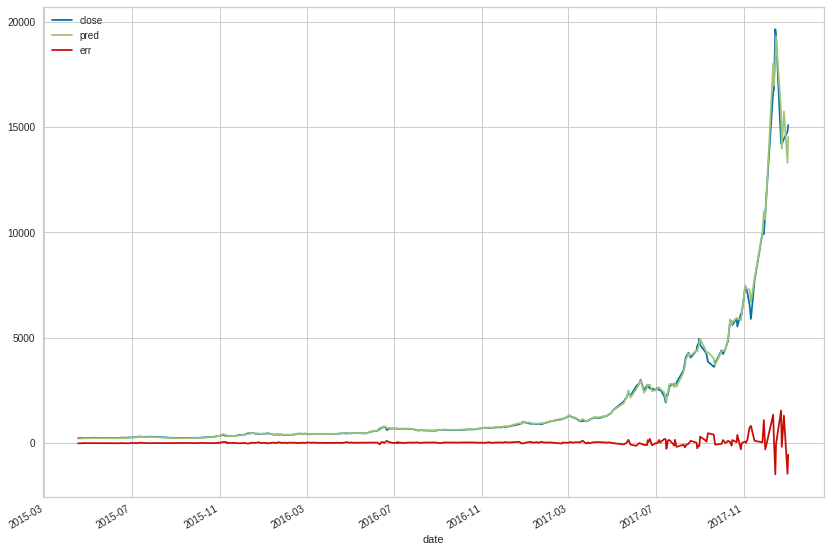

In [75]:
#look at the error
y_df2 = pd.DataFrame(y_test)
y_df2['pred'] = lr_model2.predict(X_test)
y_df2['err'] = y_df2.pred - y_df2.close
(
y_df2
    #.iloc[-50:]
    .plot(figsize=(14,10))
);

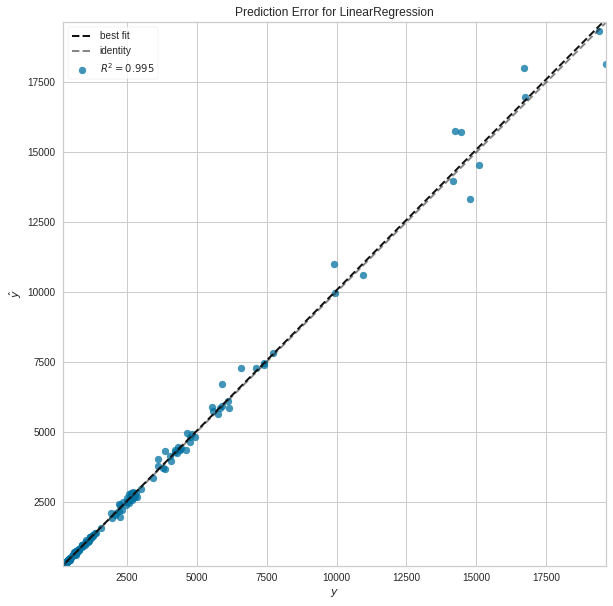

In [76]:
# yellow brick version for prediction error
fig, ax = plt.subplots(figsize=(10, 10))
err_viz2 = PredictionError(lr_model2)
err_viz2.score(X_test, y_test)
err_viz2.poof()

## Exercise: Regression with Train/Test Split

Split the data into test and training data. What is the score on the test data?

In [77]:
X_ff_train, X_ff_test, y_ff_train, y_ff_test = model_selection.\
    train_test_split(X_ff_scaled, y_ff_scaled, test_size=.3,
                     random_state=42)

In [78]:
ff_lr_scaled2 = linear_model.LinearRegression()
ff_lr_scaled2.fit(X_ff_train, y_ff_train)
ff_lr_scaled2.score(X_ff_test, y_ff_test)

-0.06015240225142282

In [79]:
ff_lr_scaled2.score(X_ff_train, y_ff_train)

0.09068605931293838

We get a negative number here, which is telling us that this is a hard regression problem. It is **overfitting**. The training score is better than the test score. 

Solutions include:
- getting more training data
- simplifying the model
- select better features

## Visualize Errors with Residual Plots
A residual is the difference between the prediction and the actual.
If we plot predicted value against residuals, we should get a random
distribution. If not, a different model more be better given the data.

In [80]:
def residual_plot(model, X_train, y_train, X_test, y_test):
    fig = plt.figure(figsize=(14,10))
    ax = plt.subplot(111)
    plt.scatter(model.predict(X_train), 
                model.predict(X_train) - y_train, 
                c='b', alpha=.3,
                label='train')
    plt.scatter(model.predict(X_test), 
                model.predict(X_test) - y_test, 
                color='green', alpha=.3,
                label='test')
    plt.title('Residual Plot - Train (blue), Test (green)')
    plt.ylabel('Residual')
    ax.legend()


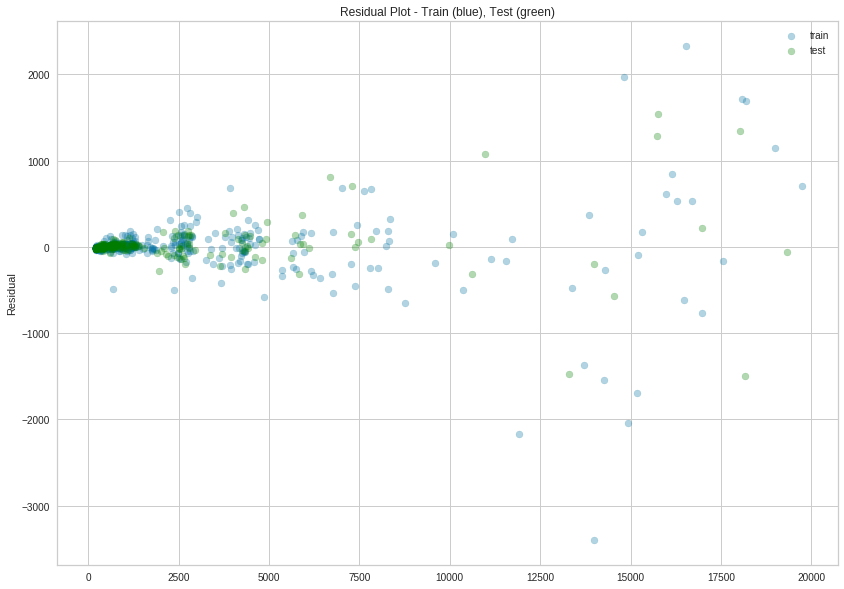

In [81]:
residual_plot(lr_model2, X_train, y_train, X_test, y_test)

We have a plot with the residual scores. As the X values get bigger the residuals get further apart. Are they randomly distributed? Yes, the residuals are not plotting on one side of 0 compared to the other so this implies that there isn't bias in the model. 

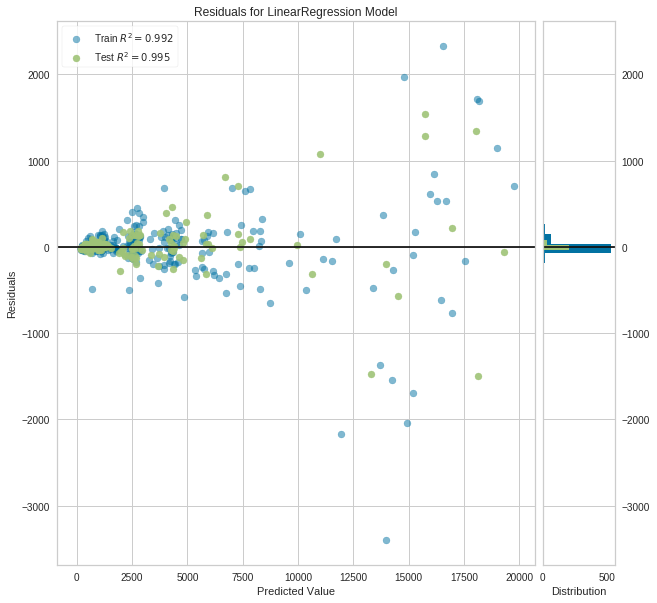

In [83]:
# Yellowbrick version
#so great! it follows the skilearn pipeline of fit and score
fig, ax = plt.subplots(figsize=(10, 10))
res_viz = ResidualsPlot(lr_model2)
res_viz.fit(X_train, y_train)
res_viz.score(X_test, y_test)
res_viz.poof()

## Exercise - Residual Plot
Make a residual plot of your test and train data

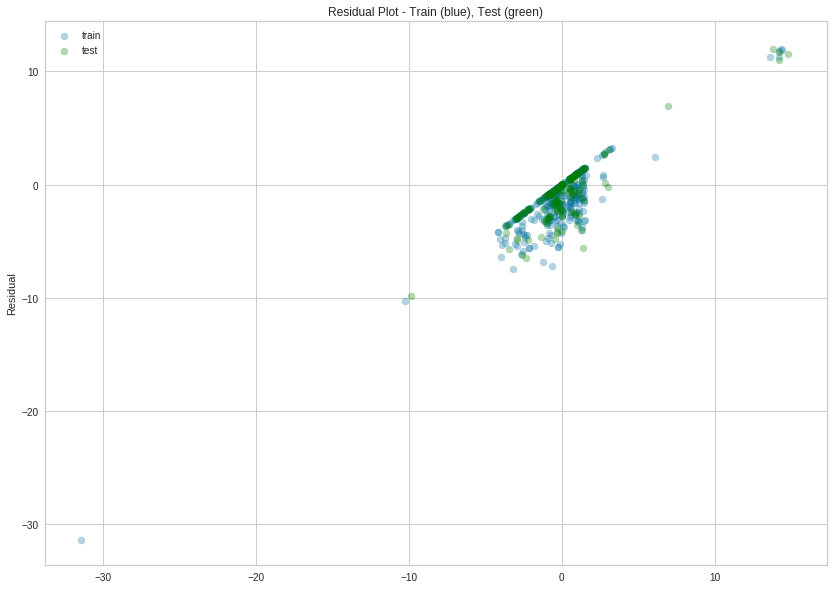

In [84]:
residual_plot(ff_lr2, X_ff_train, y_ff_train, X_ff_test, y_ff_test)

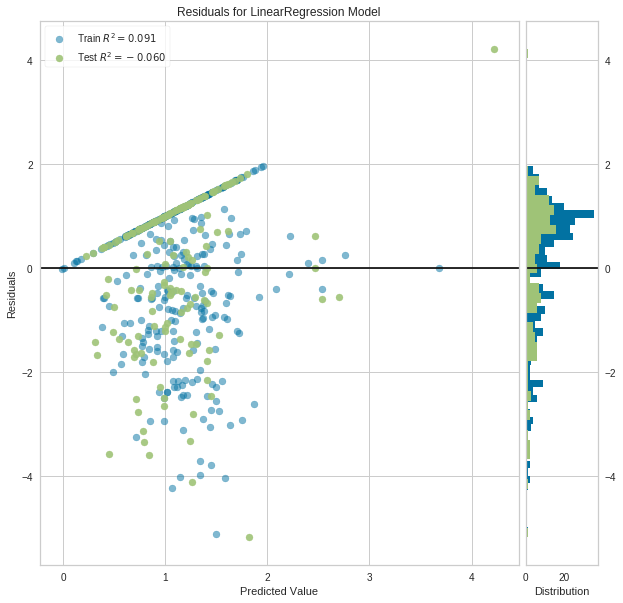

In [85]:
# Yellowbrick version
fig, ax = plt.subplots(figsize=(10, 10))
res_viz2 = ResidualsPlot(ff_lr2)
res_viz2.fit(X_ff_train, y_ff_train)
res_viz2.score(X_ff_test, y_ff_test)
res_viz2.poof()

Is there some bias in this model? further work required...

## SVM, Random Forest, & Huber  - Other models

In [86]:
# drop last row because we don't know what future is

X = (bit_df
         .drop(['close'], axis=1)
         .iloc[:-1])
y = bit_df.close.shift(-1).iloc[:-1]
cols = X.columns

ss = preprocessing.StandardScaler()
ss.fit(X)
X = ss.transform(X)
X = pd.DataFrame(X, columns=cols)

X_train, X_test, y_train, y_test = model_selection.\
    train_test_split(X, y, test_size=.3, random_state=42)
    
svm_model = svm.SVR(kernel='linear')
svm_model.fit(X_train, y_train)
svm_model.score(X_test, y_test)    

0.6981527762247227

In [87]:
def train_reg_model(model, df):
    # drop last row because we don't know what future is

    X = (df
             .drop(['close'], axis=1)
             .iloc[:-1])
    y = df.close.shift(-1).iloc[:-1]
    cols = X.columns

    ss = preprocessing.StandardScaler()
    ss.fit(X)
    X = ss.transform(X)
    X = pd.DataFrame(X, columns=cols)

    X_train, X_test, y_train, y_test = model_selection.\
        train_test_split(X, y, test_size=.3, random_state=42)

    #svm_model = svm.SVR(kernel='linear')
    model.fit(X_train, y_train)
    return model.score(X_test, y_test), X_test, y_test, X_train, y_train    
    
rf_reg = ensemble.RandomForestRegressor() 
score, X_test, y_test, X_train, y_train = train_reg_model(rf_reg, bit_df)
print(score)    

0.9938048880749508


Looks like random forest has a better score than SVM

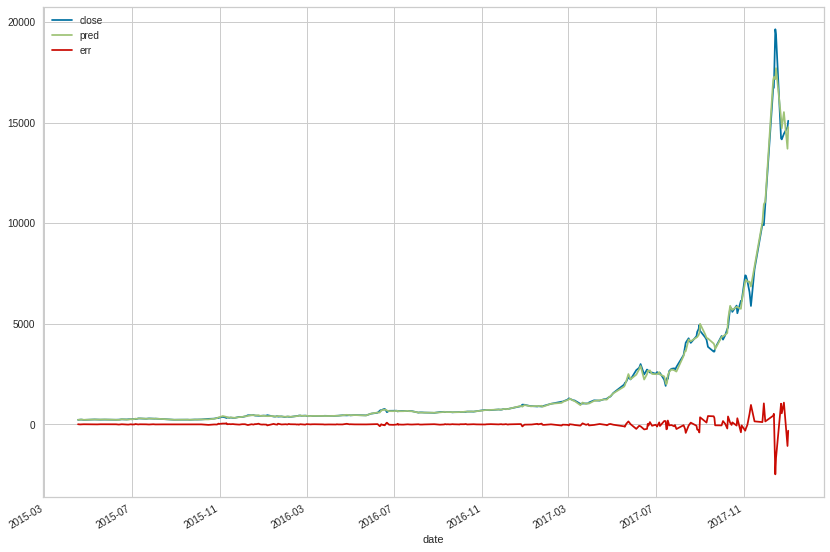

In [88]:
def error_plot(X_test, y_test, model):
    y_df3 = pd.DataFrame(y_test)
    y_df3['pred'] = model.predict(X_test)
    y_df3['err'] = y_df3.pred - y_df3.close
    (
    y_df3
     #   .iloc[-50:]
        .plot(figsize=(14,10))
    )
error_plot(X_test, y_test, rf_reg)

The error is still growing in the random forest model as it did in the linear regression model

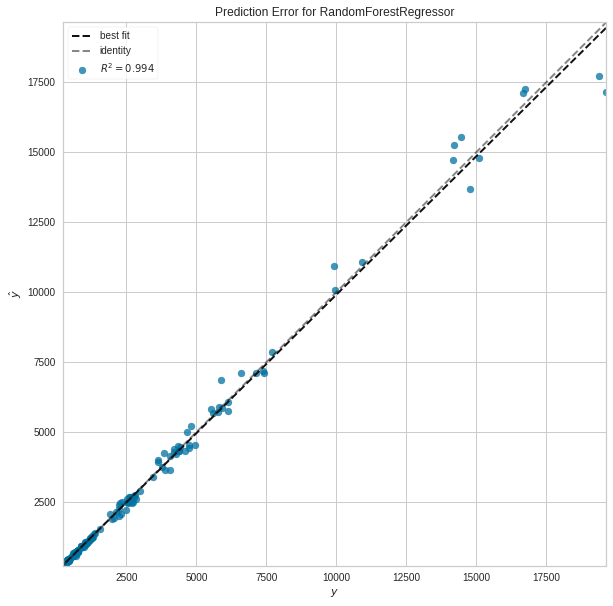

In [89]:
# yellow brick version
fig, ax = plt.subplots(figsize=(10, 10))
err_viz3 = PredictionError(rf_reg)
err_viz3.score(X_test, y_test)
err_viz3.poof()

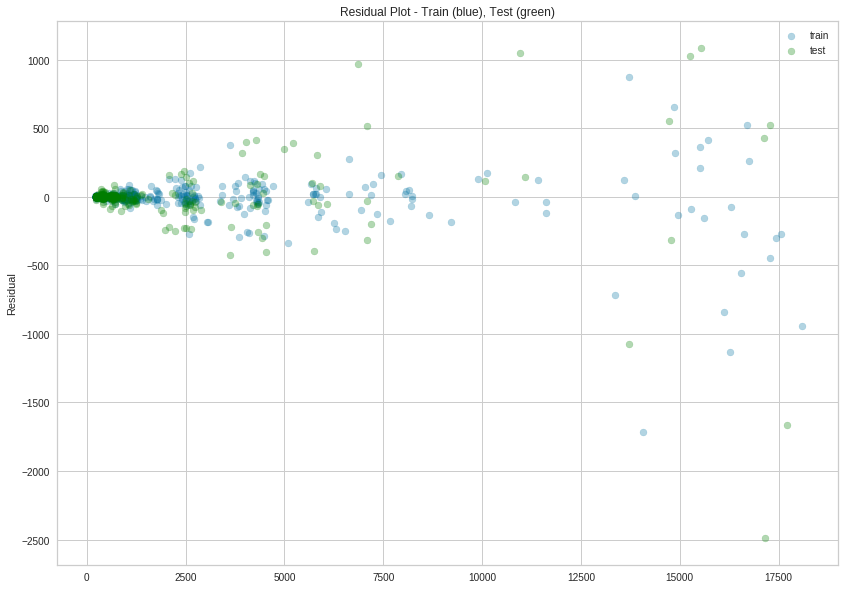

In [90]:
residual_plot(rf_reg, X_train, y_train, X_test, y_test)

and again, random forest is showing more errors as the numbers get larger. And it does look like testing and training are both having errors....overfitting?

another model the Huber Regressor

In [91]:
huber_reg = linear_model.HuberRegressor()
huber_reg.fit(X_train, y_train)
huber_reg.score(X_test, y_test)

0.9952691880977271

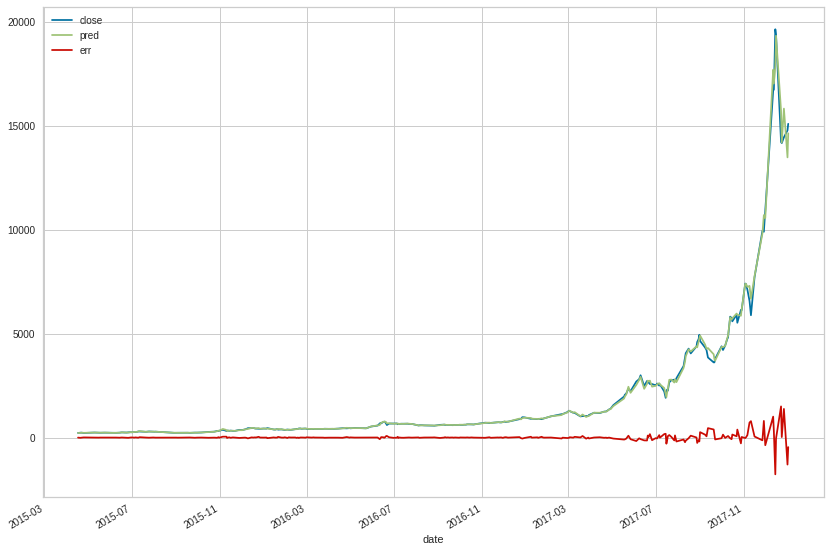

In [92]:
error_plot(X_test, y_test, huber_reg)

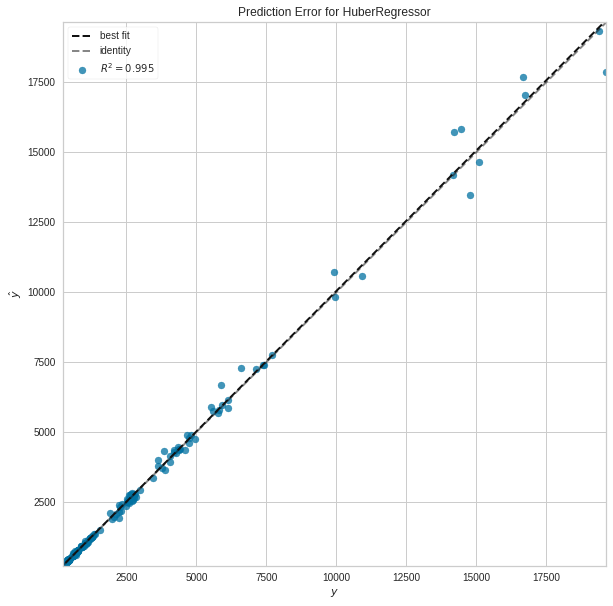

In [94]:
# yellow brick version
fig, ax = plt.subplots(figsize=(10, 10))
err_viz4 = PredictionError(huber_reg)
err_viz4.score(X_test, y_test)
err_viz4.poof()

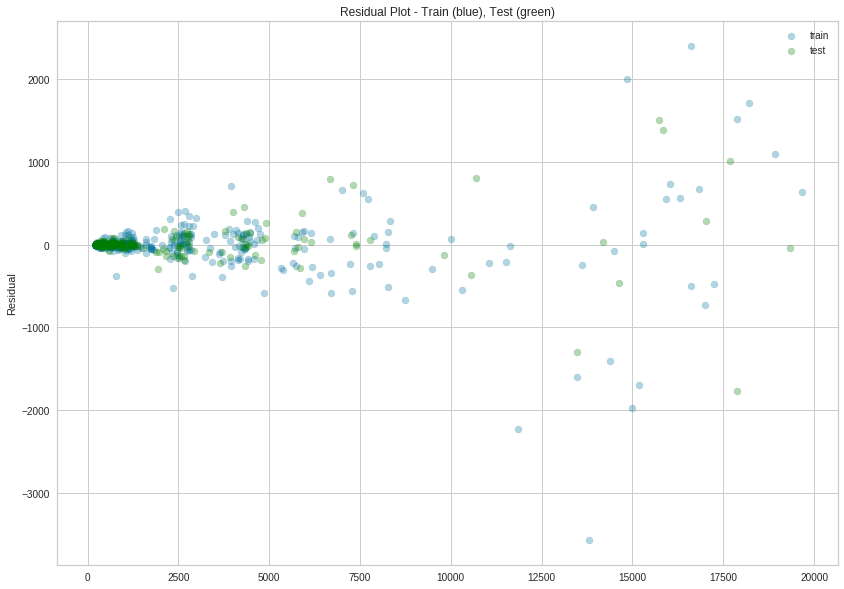

In [95]:
residual_plot(huber_reg, X_train, y_train, X_test, y_test)

In [96]:
huber_reg

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

## Exercise:

Try using another model (RandomForestRegressor or SVM)

In [97]:
rf_ff = ensemble.RandomForestRegressor()
rf_ff.fit(X_ff_train, y_ff_train)
rf_ff.score(X_ff_test, y_ff_test)

-0.1715252520710071

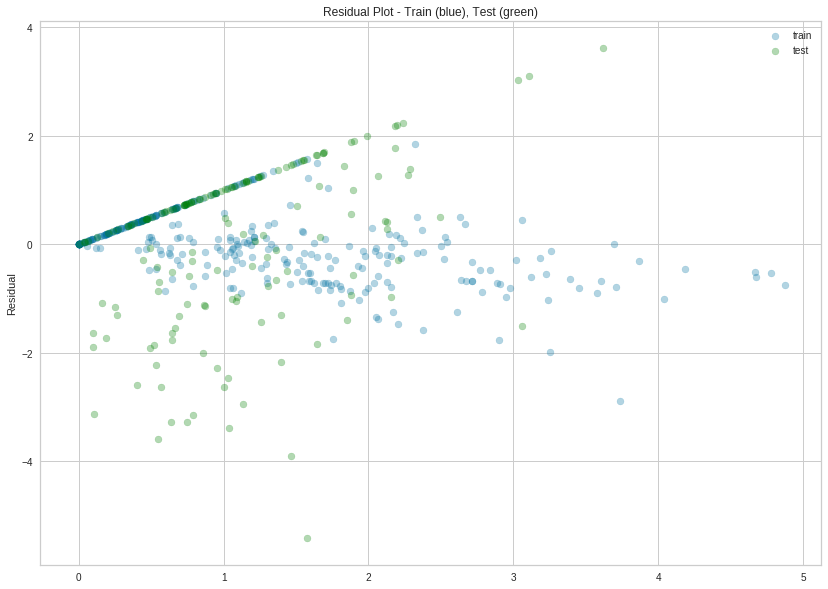

In [98]:
residual_plot(rf_ff, X_ff_train, y_ff_train, X_ff_test, y_ff_test)

In [99]:
svm_ff = svm.SVR()
svm_ff.fit(X_ff_train, y_ff_train)
svm_ff.score(X_ff_test, y_ff_test)

-0.17761583400326386